In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

import numpy as np
import pickle
import yaml
from RetaredHarmonicDynamics import animate_particle
from matplotlib import animation
from scipy.stats import moment
from scipy.special import factorial, lambertw, erf
from pathlib import Path

tensor = torch.tensor

from my_functions import get_pos, get_mean_std, FokkerPlankCalculator, time_delayed_harmonic, damped_harmonic_oszillator
from my_functions import get_approx_freq,get_zero, get_pos_with_border, get_pos_mirror, plot_bullerjahn_analysis

pic_path = Path('Graphic_Results/')

save_run = False

# num_particle = 20000
# border = 0.7e-3
# max_t = 8
# dt = 4e-3

# k = 15
# tau = 0

with open('std_parameter_setting.yaml') as f:
    std_parameter_setting = yaml.load(f , Loader=yaml.SafeLoader)
    
num_res_folder = Path('nummeric_results')/std_parameter_setting['name']
num_res_folder.mkdir(exist_ok=True)

num_particle = std_parameter_setting['num_particle']
max_t = std_parameter_setting['max_t']
dt = std_parameter_setting['dt']

tau = std_parameter_setting['tau']
k = std_parameter_setting['k']
border = std_parameter_setting['border']

D = float(std_parameter_setting['D'])

forces = {
    "no": lambda i: 0,
    "const": lambda i:2e-3,
    "ramp": lambda i: 0.005*i/(max_t),
    "oszi": lambda i: 0.005*np.cos(i * 10)
}



In [3]:
pos = get_pos_mirror(x_m = border, tau=tau, k=k,D=D,dt=dt, num_particle=10_000,max_t = 5)
last_min_tensor = torch.zeros_like(pos) # if pos = -1 last min left if pos = 1 last min right
last_min_tensor[pos <= -border] = -1
last_min_tensor[pos >= border] = 1

for i in range(len(last_min_tensor)):
    last_min_tensor[i][last_min_tensor[i] == 0] = last_min_tensor[i-1][last_min_tensor[i] == 0]

In [4]:
crossings = ((last_min_tensor[1:]*last_min_tensor[:-1]) < 0).sum(axis=0).float()

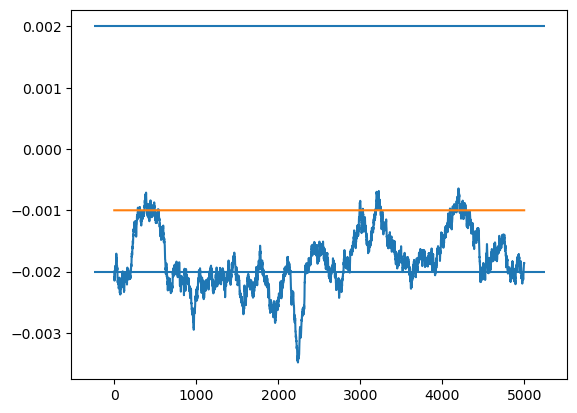

In [5]:
plt.plot(pos[:,4])
plt.plot(last_min_tensor[:,4]*0.001)
plt.hlines([-border,border],*plt.xlim())

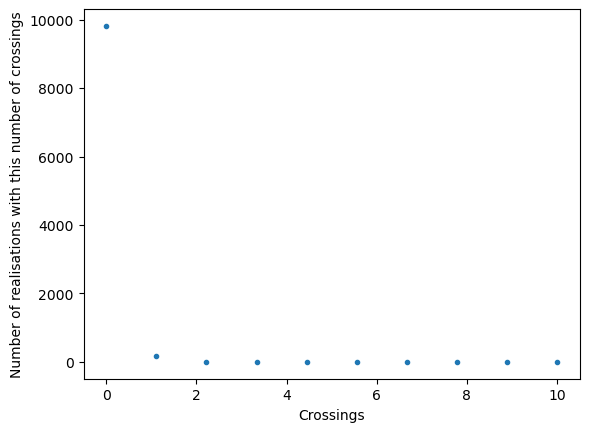

In [6]:
xlim = (0,10)
hist = crossings.histc(bins=xlim[1], min=xlim[0], max=xlim[1], )
plt.plot(np.linspace(*xlim,xlim[1]),hist,'.')
plt.xlabel('Crossings')
plt.ylabel('Number of realisations with this number of crossings')
crossings_min_bound = {tau:hist}
# %store crossings_min_bound
with open(num_res_folder/'crossings_min_bound.pkl','wb') as f:
    pickle.dump(crossings_min_bound, f)

In [7]:
def plot_simulated_rate(
    k,
    tau,
    D,
    border,
    dt,
    num_particle,
    max_t,
    F=lambda i:0,
    safe_name=None):
    pos = get_pos_mirror(x_m = border,
                         num_particle=num_particle,
                         max_t = max_t,
                         dt = dt,
                         tau=tau,
                         k=k,
                         D=D,
                         F=F)
    last_min_tensor = torch.zeros_like(pos) # if pos = -1 last min left if pos = 1 last min right
    last_min_tensor[pos <= -border] = -1
    last_min_tensor[pos >= border] = 1

    for i in range(len(last_min_tensor)):
        last_min_tensor[i][last_min_tensor[i] == 0] = last_min_tensor[i-1][last_min_tensor[i] == 0]
    print('got', len(pos))
    time = np.linspace(0,max_t,len(pos))
    particles = (pos < 0).sum(1)

    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].plot(time,particles)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Number of particles')

    p_diff_raw = particles.diff(dim=0)*1.
    crossings_raw = ((last_min_tensor[1:]*last_min_tensor[:-1]).sign() + last_min_tensor[:-1].sign() == -2).sum(axis=1)+0.
    p_diff = p_diff_raw.clone()
    crossings = crossings_raw.clone()
    
    mean_bin = 50
    p_diff = p_diff.squeeze()
    p_diff = torch.stack([p_diff.repeat(mean_bin,1).diag(i).mean() for i in range(len(p_diff)-mean_bin)])
    p_diff = p_diff.unsqueeze(1)
    time_s = time[mean_bin//2:-mean_bin//2-1]
    
    crossings = crossings.squeeze()
    crossings = torch.stack([crossings.repeat(mean_bin,1).diag(i).mean() for i in range(len(crossings)-mean_bin)])
    crossings = crossings.unsqueeze(1)
    
    # for i in range(500):
    #     p_diff[1:-1] = (p_diff[2:]+p_diff[1:-1]+p_diff[:-2])/3
    #     p_diff[0] = (p_diff[0]+p_diff[1])/2
    #     p_diff[-1] = (p_diff[-1]+p_diff[-2])/2
    #     crossings[1:-1] = (crossings[2:]+crossings[1:-1]+crossings[:-2])/3
    #     crossings[0] = (crossings[0]+crossings[1])/2
    #     crossings[-1] = (crossings[-1]+crossings[-2])/2
    
    
    axs[1].plot(time[:-1],p_diff_raw, alpha=0.2, label='raw')
    axs[1].plot(time_s,p_diff, label='smoothed')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Change of number of particles')
    axs[1].legend()
    axs[2].plot(time[:-1],crossings_raw, alpha=0.2, label='raw')
    axs[2].plot(time_s,crossings, label='smoothed')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Crossing left to right of particles')
    axs[2].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_particles.pdf')
    plt.show()
    
    rate_raw = -p_diff_raw/particles[1:]/dt
    rate = -p_diff/particles[1+mean_bin//2:-mean_bin//2]/dt
    crossing_rate = crossings/particles[1+mean_bin//2:-mean_bin//2]/dt
    crossing_rate_raw = crossings_raw/particles[1:]/dt
    
    # plt.plot(time[:-1],rate_raw, alpha=0.2)
    # plt.plot(time[:-1],rate)
    
    plt.plot(time[:-1],crossing_rate_raw, alpha=0.2)
    plt.plot(time_s,crossing_rate)
    
    average = 500
    print(rate_raw[-average:].mean(), 1/np.sqrt(average)*rate_raw[-average:].std())
    plt.xlabel("Time")
    plt.ylabel(r"Rate $\kappa$")
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_rate.pdf')
    plt.show()
    return pos,particles,rate,crossing_rate, time, time_s

# No Force

got 2000


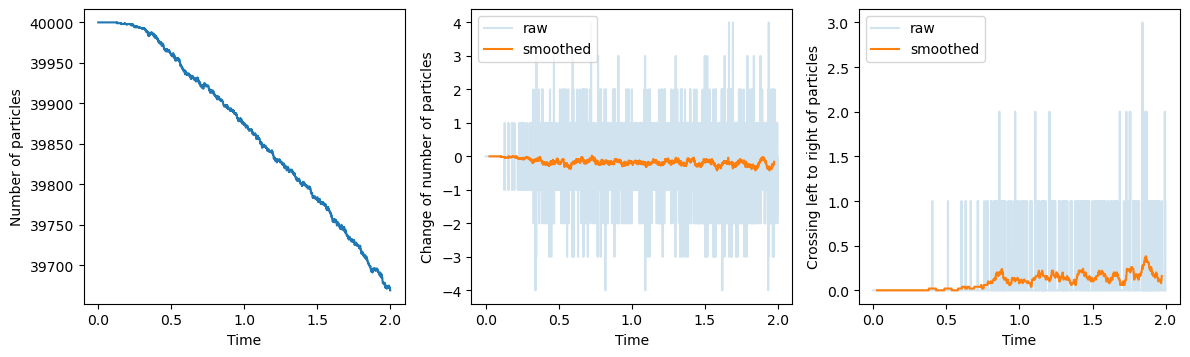

tensor(0.0058) tensor(0.0015)


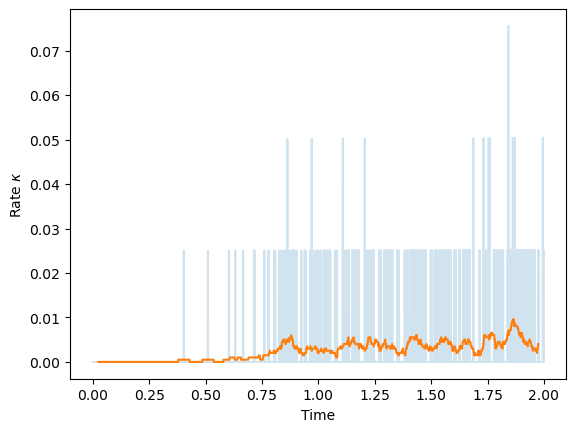

In [8]:
pos, particles_no_force, rate_no_force,crossing_rate_no_force, time_no_force, time_no_force_s = plot_simulated_rate(
    k=k,
    tau=tau,
    D=D,
    border=border,
    num_particle=num_particle,
    max_t=max_t,
    dt=dt,
    F = forces['no'],
    safe_name='no_force')

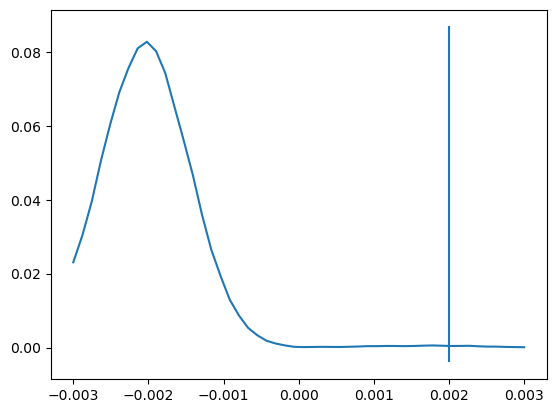

In [9]:
average = 50
xlim = (-3e-3,3e-3)
values = pos[-average:,:,0].flatten()
hist = values[~values.isnan()].float().histc(bins=50, min=xlim[0], max=xlim[1], )/num_particle/average

plt.plot(np.linspace(*xlim,50),hist)
plt.vlines([border],*plt.ylim())

# Const Force

got 2000


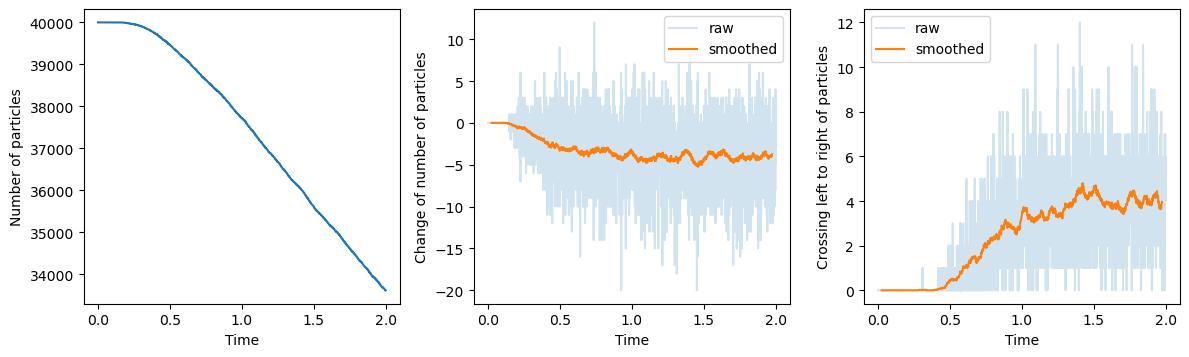

tensor(0.1152) tensor(0.0057)


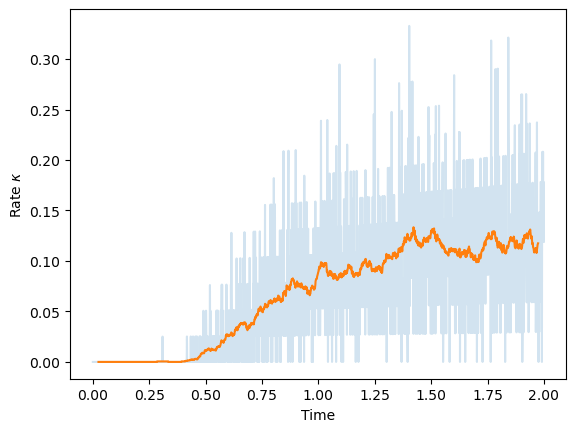

In [10]:
pos, particles_const, rate_const, crossing_rate_const ,time_const, time_const_s = plot_simulated_rate(
    tau=tau,
    k=k,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['const'],
    max_t=max_t,
    dt=dt,
    safe_name='const_force')
    
#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Force Ramp

got 2000


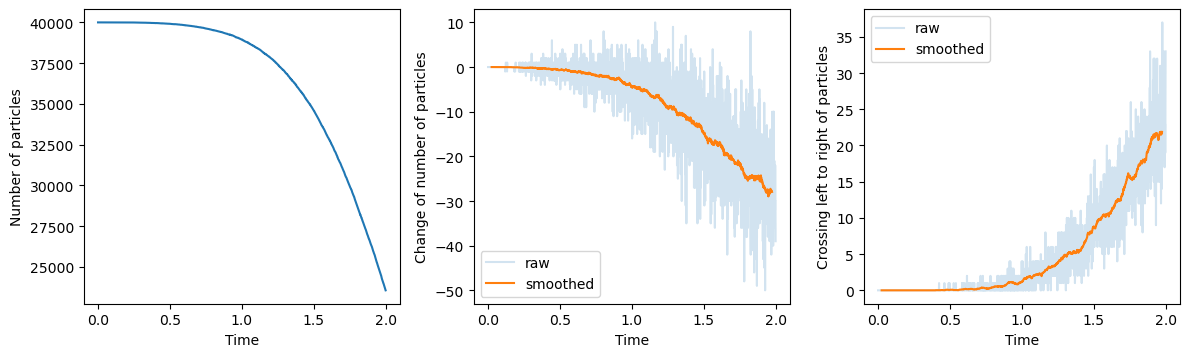

tensor(0.7687) tensor(0.0168)


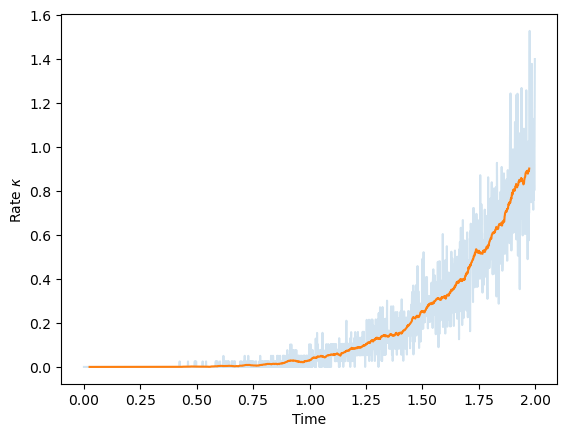

In [11]:
pos, particles_ramp, rate_ramp,crossing_rate_ramp, time_ramp, time_ramp_s = plot_simulated_rate(
    k=k,
    tau=tau,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['ramp'],
    max_t = max_t,
    dt=dt,
    safe_name='force_ramp')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Oszillatory driving

got 2000


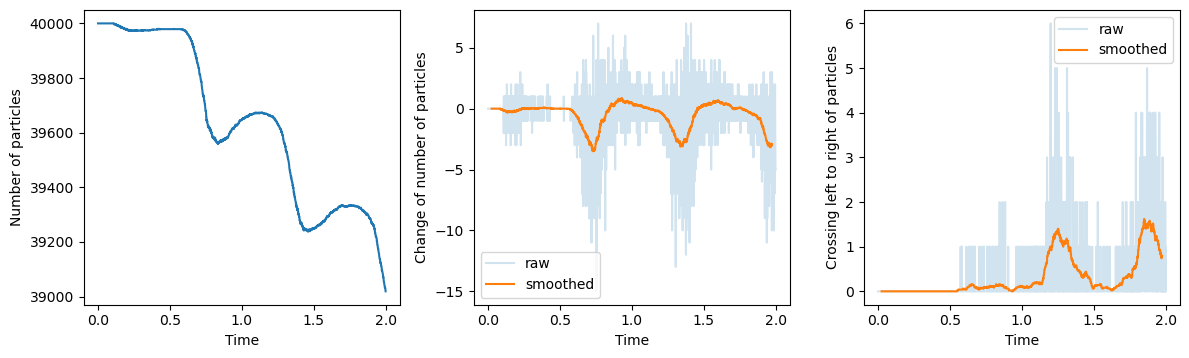

tensor(0.0119) tensor(0.0024)


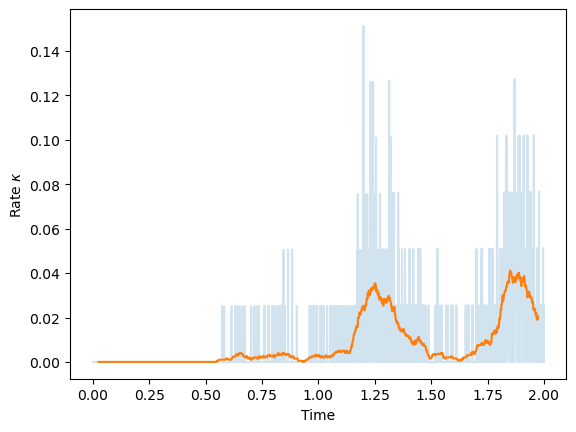

In [12]:
pos, particles_oszi, rate_oszi,crossing_rate_oszi, time_oszi, time_oszi_s = plot_simulated_rate(
    k=k,
    tau = tau,
    D=D,
    num_particle=num_particle,
    border=border,
    F= forces['oszi'],
    max_t = max_t, 
    dt=dt,
    safe_name='oszi_force')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Bullerjahn

In [13]:
# sim_res = {
#     "no": rate_no_force,
#     "const": rate_const,
#     "ramp": rate_ramp,
#     "oszi": rate_oszi
# }

sim_res = {
    "no": crossing_rate_no_force,
    "const": crossing_rate_const,
    "ramp": crossing_rate_ramp,
    "oszi": crossing_rate_oszi
}

sim_res_num = {
    "no": particles_no_force/num_particle,
    "const": particles_const/num_particle,
    "ramp": particles_ramp/num_particle,
    "oszi": particles_oszi/num_particle
}

forces_bound_min = forces
sime_res_bound_min = sim_res
# %store sime_res_bound_min
with open(num_res_folder/'sime_res_bound_min.pkl','wb') as f:
    pickle.dump(sime_res_bound_min, f)

1000


/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:395: RuntimeWarning: divide by zero encountered in divide
  j = -(w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:395: RuntimeWarning: invalid value encountered in multiply
  j = -(w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:397: RuntimeWarning: divide by zero encountered in divide
  S = 1/2*(1+erf( (b-mu)/np.sqrt(2*var)))
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/my_functions.py:407: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[0,0].set_ylim(0.9*np.sort(G)[11], 1.1*np.sort(G)[-11])


1000
1000
1000


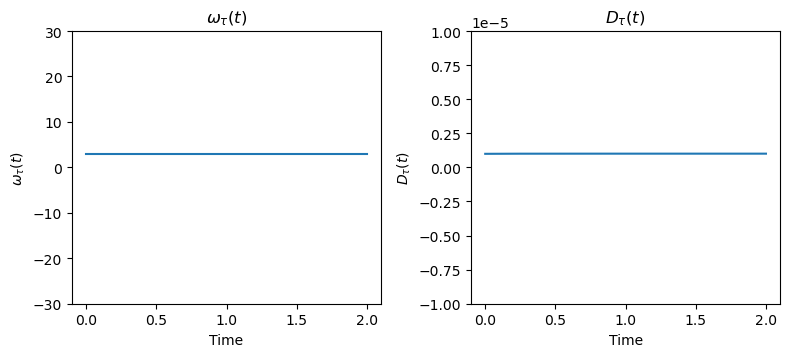

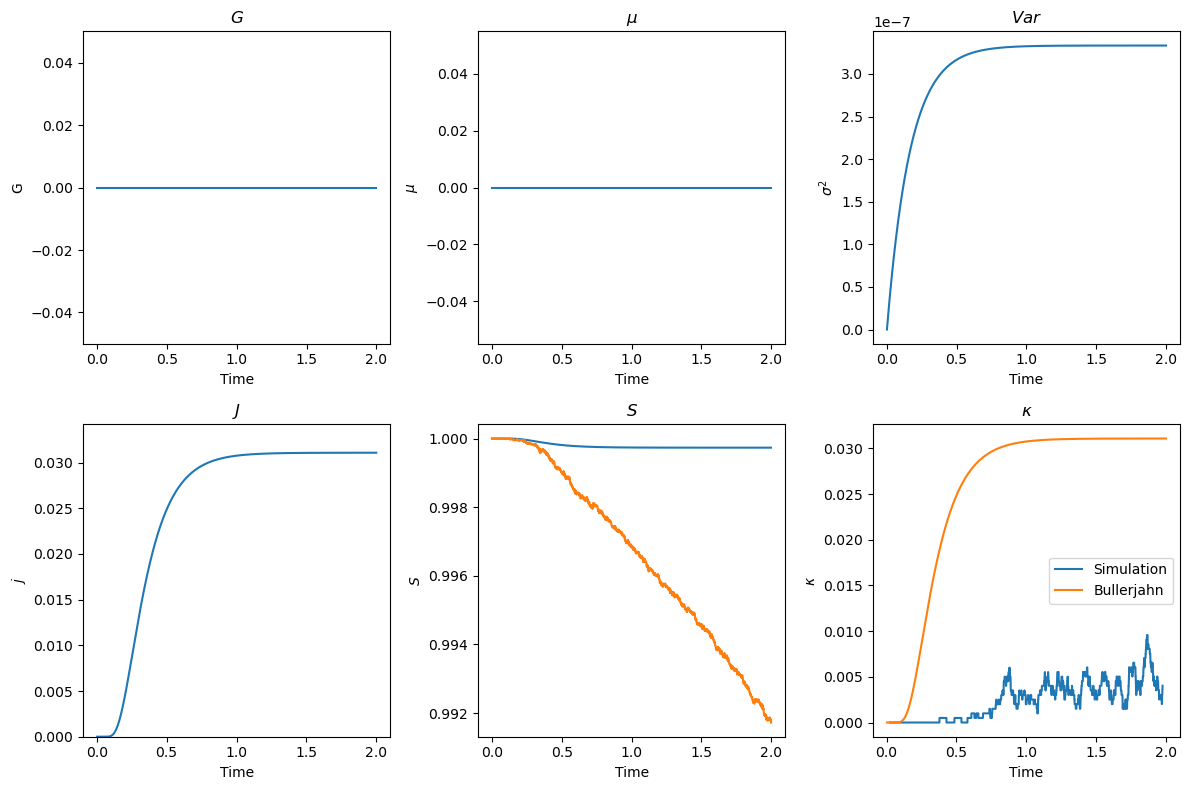

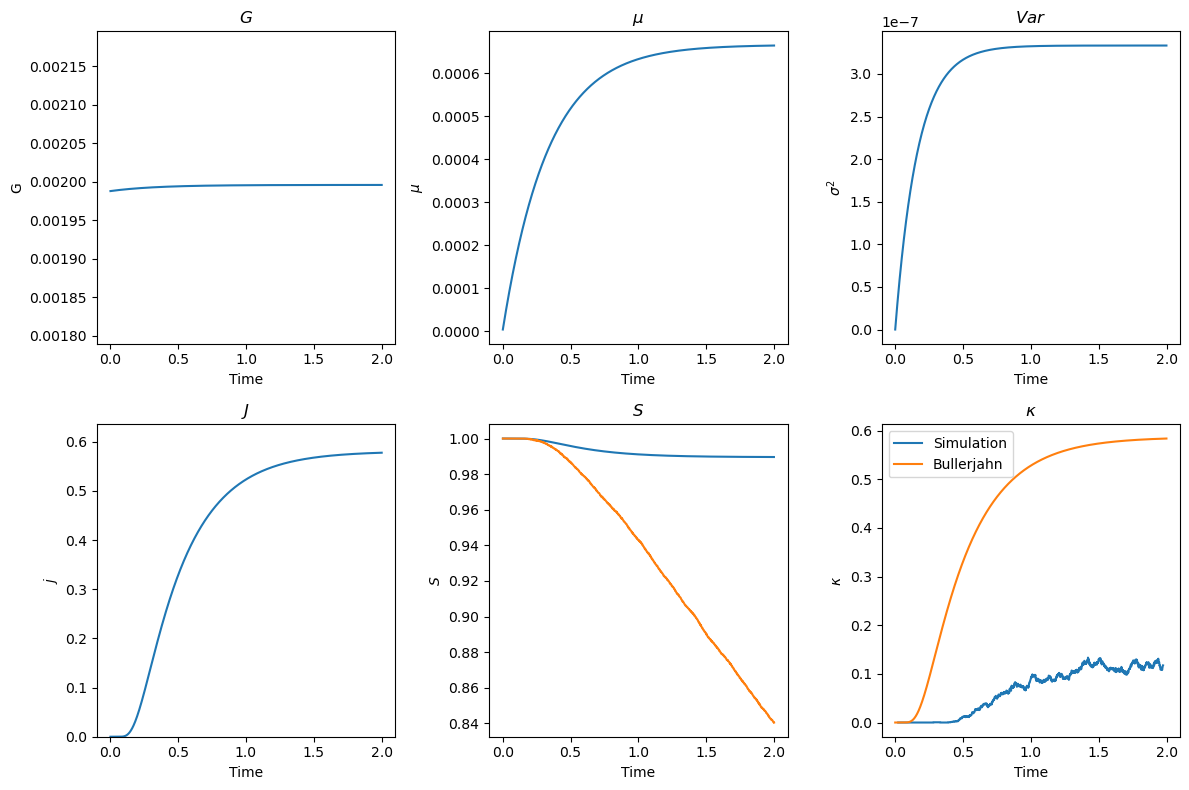

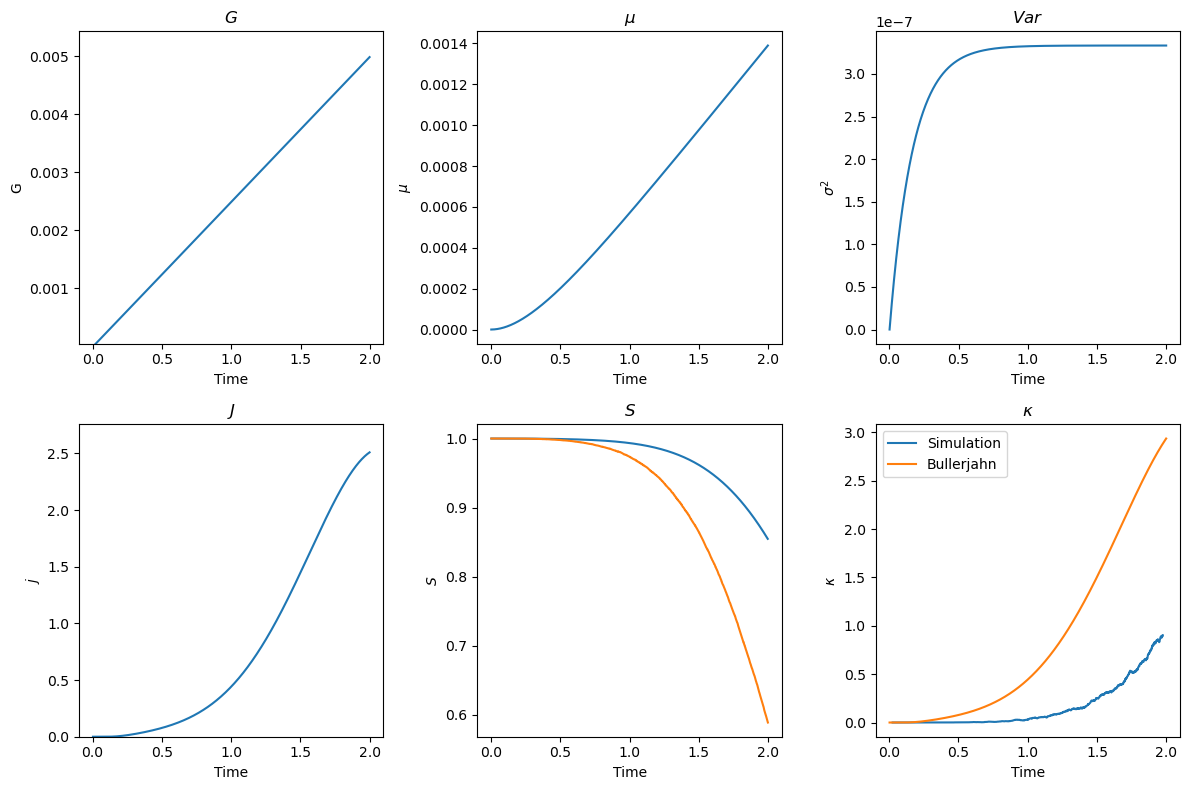

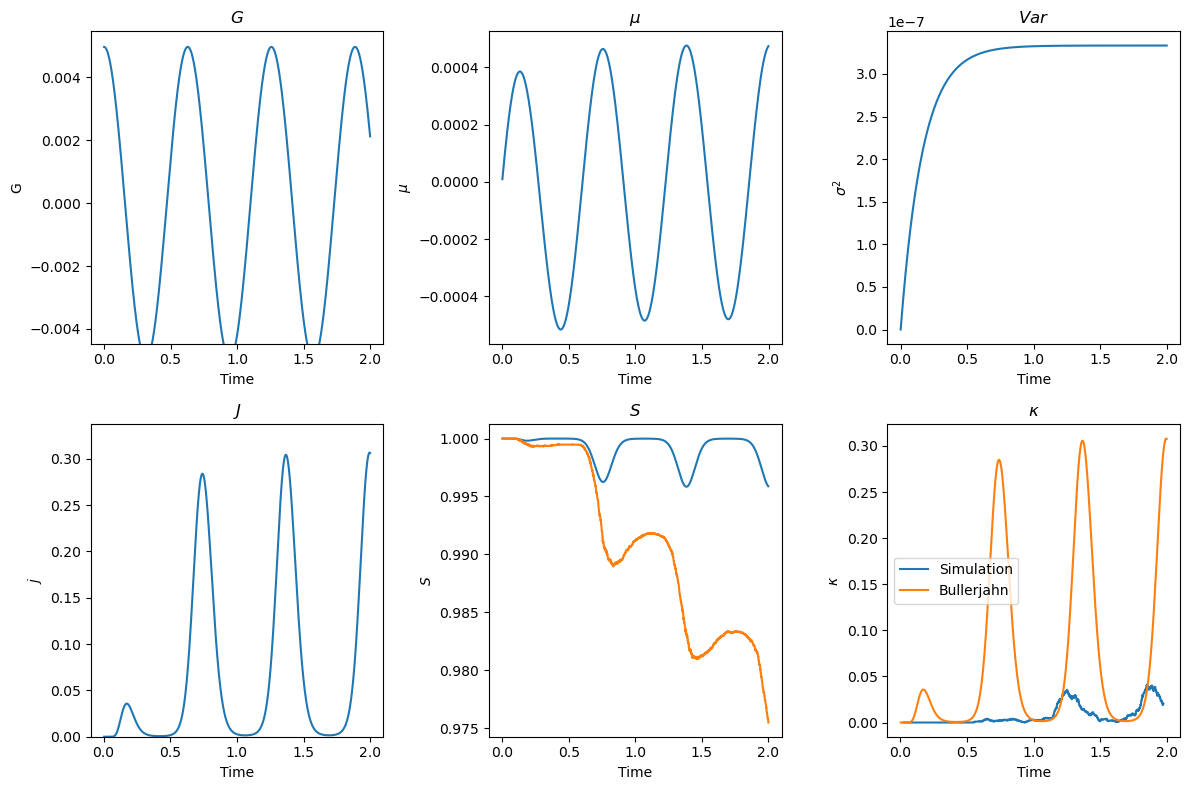

In [14]:
plot_bullerjahn_analysis(max_t, dt, tau, k, D,border, time_ramp_s, sim_res,time_ramp, sim_res_num, forces, save_run)
plt.show()